In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')
import sys

!git clone -b recovery6 https://github.com/wjteng/LBC-IoT-Key-Recovery.git

sys.path.insert(0,'/content/LBC-IoT-Key-Recovery')

import numpy as np
from os import urandom
import lbciot as cipher
import pandas as pd
import train_nets as tn

rounds = 5;
epoch = 40;
diff1 = 0x2000;
diff2 = 0x0000;

name = str(diff1)+"_"+str(diff2)+"_r="+str(rounds)+"_epoch="+str(epoch);

model, h =tn.train_distinguisher(epoch,(diff1,diff2),num_rounds=rounds,depth=10);

model.save('/content/gdrive/MyDrive/LBC-IoT-Key-Recovery/'+name);

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
fatal: destination path 'LBC-IoT-Key-Recovery' already exists and is not an empty directory.
Epoch 1/40
200/200 [==============================] - 26s 108ms/step - loss: 0.2596 - acc: 0.5002 - val_loss: 0.2579 - val_acc: 0.4987 - lr: 0.0020
Epoch 2/40
200/200 [==============================] - 21s 105ms/step - loss: 0.2570 - acc: 0.5033 - val_loss: 0.2562 - val_acc: 0.5009 - lr: 0.0018
Epoch 3/40
200/200 [==============================] - 21s 105ms/step - loss: 0.2556 - acc: 0.5079 - val_loss: 0.2550 - val_acc: 0.5039 - lr: 0.0016
Epoch 4/40
200/200 [==============================] - 21s 106ms/step - loss: 0.2542 - acc: 0.5170 - val_loss: 0.2537 - val_acc: 0.5155 - lr: 0.0014
Epoch 5/40
200/200 [==============================] - 21s 106ms/step - loss: 0.2507 - acc: 0.5424 - val_loss: 0.2485 - val_acc: 0.5601 - lr: 0.0012
Epoch 6/40
200/200 [==============

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
fatal: destination path 'LBC-IoT-Key-Recovery' already exists and is not an empty directory.
0
10000
20000
30000
40000
50000
60000


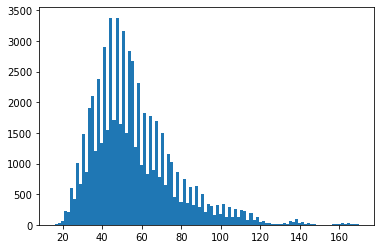

found max:16661
correct key:49175
[[16661   170]
 [20663   170]
 [49173   170]
 [53271   170]
 [53429   170]
 [16405   169]
 [20501   169]
 [20535   169]
 [20629   169]
 [49301   169]
 [49553   169]
 [49555   169]
 [49557   169]
 [49589   169]
 [53399   169]
 [53431   169]
 [16785   168]
 [20503   168]
 [20631   168]
 [49425   168]
 [49429   168]
 [53395   168]
 [53397   168]
 [53525   168]
 [16401   167]
 [16535   167]
 [16789   167]
 [16817   167]
 [20625   167]
 [20657   167]]


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')
import sys

!git clone -b recovery6 https://github.com/wjteng/LBC-IoT-Key-Recovery.git

sys.path.insert(0,'/content/LBC-IoT-Key-Recovery')

import numpy as np
from os import urandom
import lbciot as cipher
import pandas as pd
import train_nets as tn
from timeit import default_timer as timer

start = timer()



n = 200; #number of plaintext pairs

rounds = 5;
epoch = 40;
diff1 = 0x0020;
diff2 = 0x0000;

key = np.frombuffer(urandom(10),dtype=np.uint16).reshape(5,-1);
keys = np.frombuffer(urandom(10*n),dtype=np.uint16).reshape(5,-1)*0+1 ;


for i in range(0,n):
  for j in range(0,5):
    keys[j][i]=key[j];


pt0l = np.frombuffer(urandom(2*n),dtype=np.uint16);
pt0r = np.frombuffer(urandom(2*n),dtype=np.uint16);

p0l = np.copy(pt0l); 
p0r = np.copy(pt0r);

p1l = p0l^diff1;
p1r = p0r^diff2;

ks = cipher.expand_key(keys, rounds + 1);

c0l,c0r = cipher.encrypt((p0l,p0r),ks);
c1l,c1r = cipher.encrypt((p1l,p1r),ks);



from tensorflow import keras

name = str(diff1)+"_"+str(diff2)+"_r="+str(rounds)+"_epoch="+str(epoch);
model = keras.models.load_model('/content/gdrive/MyDrive/LBC-IoT-Key-Recovery/'+name);

allkeys = ks[rounds]*0;

count = np.zeros(2**16,dtype=int);

for i in range(0,2**16):
  if i%10000==0:
    print(i);
  c0l_dec1,c0r_dec1 = cipher.dec_one_round((c0l,c0r),allkeys);
  c1l_dec1,c1r_dec1 = cipher.dec_one_round((c1l,c1r),allkeys);
  X = cipher.convert_to_binary([c0l_dec1,c0r_dec1,c1l_dec1,c1r_dec1]);
  Z = model.predict(X,batch_size=10000);
  count[allkeys[0]] =  np.sum(Z>0.5);
  allkeys = allkeys + 1;

df = pd.DataFrame(count);
df.to_csv('/content/gdrive/MyDrive/LBC-IoT-Key-Recovery/'+'count_'+str(diff1)+'_'+str(diff2)+'_CorrectKey='+str(ks[rounds][0])+'.csv');

import matplotlib.pyplot as plt

plt.hist(count, bins=100)
plt.savefig('/content/gdrive/MyDrive/LBC-IoT-Key-Recovery/'+name+'_counthist.png')
plt.show()


count[np.argmax(count)]
print('found max:'+str(np.argmax(count)))
print('correct key:'+str(ks[rounds][0]));
count[41855]
sorted_count = -np.sort(-count);
temp = count;
top = 50;
rank = np.zeros((top,2),dtype=int);
for i in range(0,top):
  max_index = np.argmax(temp);
  rank[i][0] = max_index;
  rank[i][1] = temp[max_index];
  temp[max_index]=-1;

print(rank);

end = timer()
print(end - start)